In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from helpers import *

In [2]:
elements = ['Ta','Sb','Nb','Fe','V','Ti']

# define colors for each element
import matplotlib.cm as cm
cmap = cm.get_cmap('Accent_r')
colors = [cmap(ii) for ii in range(len(elements))]
print(colors)

[(0.4, 0.4, 0.4, 1.0), (0.7490196078431373, 0.3568627450980392, 0.09019607843137253, 1.0), (0.9411764705882353, 0.00784313725490196, 0.4980392156862745, 1.0), (0.2196078431372549, 0.4235294117647059, 0.6901960784313725, 1.0), (1.0, 1.0, 0.6, 1.0), (0.9921568627450981, 0.7529411764705882, 0.5254901960784314, 1.0)]


C:\Users\M6NJOHNS\AppData\Local\Temp\ipykernel_37040\2369450934.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('Accent_r')


In [3]:
# import the dataset as a pandas dataframe
fpath = 'Ti-Nb-V-Ta-Fe-Sb_sputtering_data_complete_clean.csv'

df = pd.read_csv(fpath,header=0)
print(df.keys())

#train_variables = ['Nb_power_watts','Sb_power_watts','Ta_power_watts','V_power_watts']
train_variables = ['Ta_power_watts','Ta_angle_mm',
                   'Sb_power_watts','Sb_angle_mm',
                   'Nb_power_watts','Nb_angle_mm',
                   'Ti_power_watts','Ti_angle_mm',
                   'Fe_power_watts','Fe_angle_mm',
                   'V_power_watts','V_angle_mm',]
predict_variables = ['Ta_measured_percent','Sb_measured_percent','Nb_measured_percent','Ti_measured_percent','Fe_measured_percent','V_measured_percent']
variable_names = ['Ta','Sb','Nb','Ti','Fe','V']

X_all,y_all = ingest_sputtering_data(fpath,train_variables = train_variables,predict_variables = predict_variables)

Index(['sample_name', 'Nb_power_watts', 'Nb_angle_mm', 'Ta_power_watts',
       'Ta_angle_mm', 'Ti_power_watts', 'Ti_angle_mm', 'Sb_power_watts',
       'Sb_angle_mm', 'Fe_power_watts', 'Fe_angle_mm', 'V_power_watts',
       'V_angle_mm', 'Ti_measured_percent', 'Fe_measured_percent',
       'Ta_measured_percent', 'Nb_measured_percent', 'Sb_measured_percent',
       'V_measured_percent', 'sum_percent'],
      dtype='object')


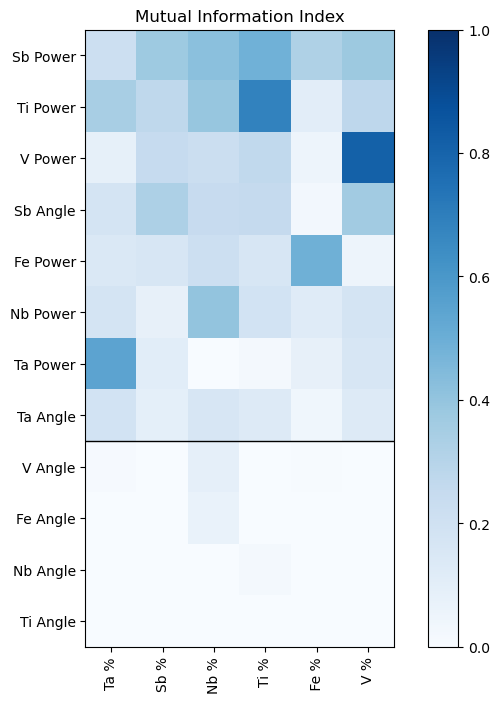

In [5]:
# calculate the mutual information index
from sklearn.feature_selection import mutual_info_regression

# some plot labels
X_corr_labels = ['Ta Power',
                   'Ta Angle',
                   'Sb Power','Sb Angle',
                   'Nb Power','Nb Angle',
                   'Ti Power','Ti Angle',
                   'Fe Power','Fe Angle',
                   'V Power','V Angle']

y_corr_labels = ['Ta %', 'Sb %', 'Nb %', 'Ti %',' Fe %', 'V %']
labels_index = np.arange(len(X_corr_labels))

# calculate the MII for all inputs and outputs
all_mi = []
for y in y_all:
    all_mi.append(mutual_info_regression(X_all.T,y))

# convert to array
all_mi = np.array(all_mi).T

# sort by most important to least important features
args = np.argsort(np.sum(all_mi,axis=1))
args = np.flip(args)
all_mi = all_mi[args]

#create the figure
plt.figure(figsize=(7,7))
im2 = plt.imshow(all_mi, cmap = 'Blues', vmin = 0, vmax= 1)

plt.xticks(range(len(y_corr_labels)),y_corr_labels,rotation='vertical')

plot_yticks = []
for arg in args:
    plot_yticks.append(X_corr_labels[arg])
plt.yticks(range(len(X_corr_labels)),plot_yticks)

cbar = plt.colorbar(im2)

plt.plot(np.arange(-0.5,6.5),np.ones(7)+6.5,'k',linewidth=1)

plt.tight_layout()
plt.title('Mutual Information Index')
plt.savefig('figures/inputs_outputs_mutual_info.png') 

C:\Users\M6NJOHNS\AppData\Local\Temp\ipykernel_37040\3688093948.py:96: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels([None,5,10,15,20,25,30])
C:\Users\M6NJOHNS\AppData\Local\Temp\ipykernel_37040\3688093948.py:97: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels([None,2,4,6,8,10,12])


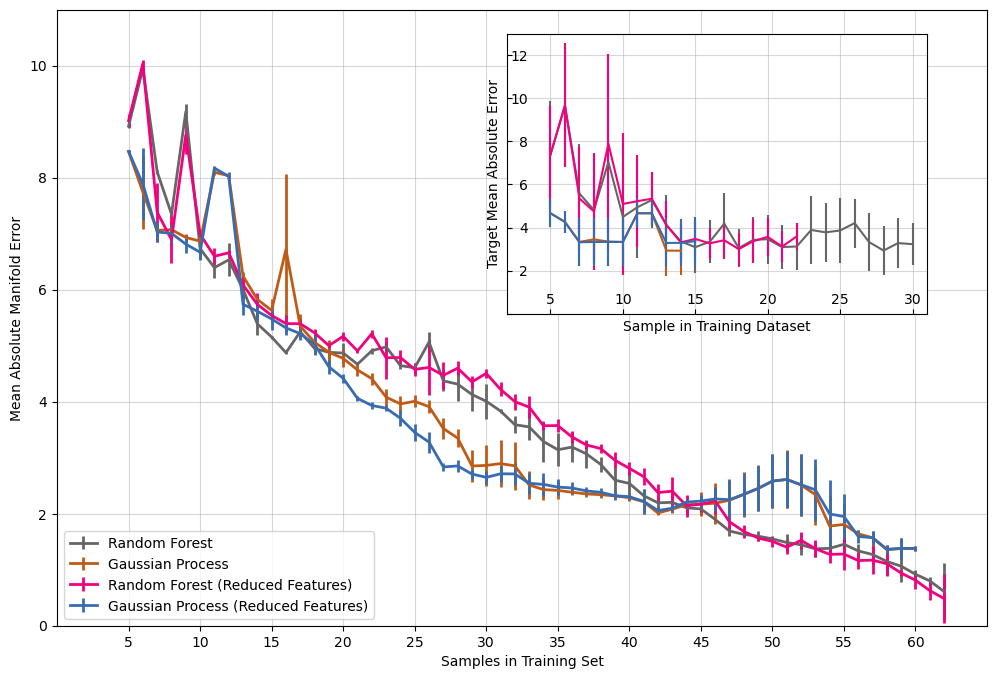

In [8]:
# Plot the total error for all models
fig = plt.figure(figsize=(12,8))
ax = plt.subplot(111)

model_fpaths = [
                'errors/RFDT_regression_error_averaged_six_runs.csv',
                'errors/GPR_regression_error_averaged_six_runs.csv',
                'errors/RFDT_regression_error_averaged_six_runs_reduced_inputs.csv',
                'errors/GPR_regression_error_averaged_six_runs_reduced_inputs.csv',
                ]

model_labels = ['Random Forest',
                'Gaussian Process',
                'Random Forest (Reduced Features)',
                'Gaussian Process (Reduced Features)'
                ]

for jj,fpath,label in zip(range(len(model_labels)),model_fpaths,model_labels):
    df = pd.read_csv(fpath)
    im = ax.errorbar(range(5,len(df['mae'])+5), df['mae'],yerr=df['yerr'],
                     c=cmap(jj),label=label,
                     linewidth=2)


plt.xlabel('Samples in Training Set')
plt.ylabel('Mean Absolute Manifold Error') 
plt.legend(loc=3)

plt.xlim(0,65)
plt.ylim(0,11)

plt.xticks(ticks=range(5,len(df['mae'])+5,5))
ax.grid(alpha=0.5)


# inset figure of target errors
###############################################
left,bottom,width,height = [0.5,0.5,0.35,0.35]

ax2 = fig.add_axes([left, bottom, width, height])

# these are plots for the errors when doing targeted synthesis
model_fpaths = [
                'errors/RFDT_regression_target_error_averaged_six_runs.csv',
                'errors/GPR_regression_target_error_averaged_six_runs.csv',
                'errors/RFDT_regression_target_error_averaged_six_runs_reduced_inputs.csv',
                'errors/GPR_regression_target_error_averaged_six_runs_reduced_inputs.csv',
                ]

model_labels = ['Random Forest Decision Trees',
                'Gaussian Process Regression',
                'Random Forest Decision Trees - Reduced Inputs',
                'Gaussian Process Regression - Reduced Inputs'
                ]

# set the linewidth for hte plot
linewidth = 1.5
markersize=5
marker='o'

for jj,fpath,label in zip(range(len(model_labels)),model_fpaths,model_labels):

    #import data
    df = pd.read_csv(fpath)

    # we want to stop plotting once the error gets below 3%
    plot_mae = []
    plot_yerr = []
    for mae,yerr in zip(df['target_mae'],df['yerr']):
        if mae > 2.85:
            plot_mae.append(mae)
            plot_yerr.append(yerr)
        else:
            break

    

    im = ax2.errorbar(range(5,len(plot_mae)+5), plot_mae, yerr = plot_yerr,
                     c=cmap(jj),label=label,linestyle='-',
                     linewidth=linewidth,markersize=markersize)


# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)
ax2.grid(alpha=0.5)
ax2.set_ylim(0,13)
ax2.set_xlim(2,31)

#ax2.legend()


ax2.set_xlabel('Sample in Training Dataset')
ax2.set_ylabel('Target Mean Absolute Error')
ax2.tick_params(axis="x",direction='in',pad=-15)
ax2.tick_params(axis="y",direction='in',pad=-15)
ax2.set_xticklabels([None,5,10,15,20,25,30])
ax2.set_yticklabels([None,2,4,6,8,10,12])


plt.savefig('figures/all_errors_target_and_manifold.png')

C:\Users\M6NJOHNS\AppData\Local\Temp\ipykernel_37040\3789556624.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap2 = cm.get_cmap('Dark2')


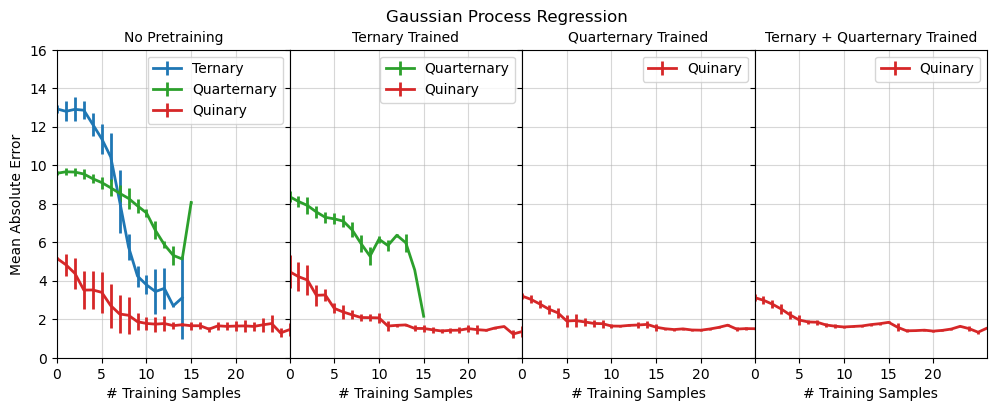

In [9]:
# now let's make the transfer learning figures

cmap2 = cm.get_cmap('Dark2')

GPR_error_fpaths = ['GPR_ternary_only_transfer_learn.csv',
'GPR_quarternary_only_transfer_learn.csv',
'GPR_quinternary_only_transfer_learn.csv',
'GPR_quarternary_from_ternary_transfer_learn.csv',
'GPR_quinternary_from_ternary_transfer_learn.csv',
'GPR_quinternary_from_quarternary_transfer_learn.csv',
'GPR_quinternary_from_all_transfer_learn.csv']

RF_error_fpaths = ['RFDT_ternary_only_transfer_learn.csv',
'RFDT_quarternary_only_transfer_learn.csv',
'RFDT_quinternary_only_transfer_learn.csv',
'RFDT_quarternary_from_ternary_transfer_learn.csv',
'RFDT_quinternary_from_ternary_transfer_learn.csv',
'RFDT_quinternary_from_quarternary_transfer_learn.csv',
'RFDT_quinternary_from_all_transfer_learn.csv']

df_labels = ['ternary','quarternary','quinternary']

# set the linewidth for the plot
linewidth = 2
markersize=10

# set colors for the various prediction compositions
cmaps = ['tab:blue','tab:green','tab:red','tab:green','tab:red','tab:red','tab:red']
labels = ['Ternary','Quarternary','Quinary','Quarternary','Quinary','Quinary','Quinary']


fig1,ax1 = plt.subplots(1,4,figsize=(12,4))
for ii,rf in enumerate(GPR_error_fpaths):
    df = pd.read_csv('errors/' + rf,header=0)
    if 'only' in rf:
        ax1[0].errorbar(range(len(df['mae'])),df['mae'],yerr=df['yerr'],
                   c=cmaps[ii],label=labels[ii],
                   linewidth=linewidth)
    elif '_from_ternary' in rf:
        ax1[1].errorbar(range(len(df['mae'])),df['mae'],yerr=df['yerr'],
                   c=cmaps[ii],label=labels[ii],
                   linewidth=linewidth)
    elif 'from_quarternary' in rf:
        ax1[2].errorbar(range(len(df['mae'])),df['mae'],yerr=df['yerr'],
                   c=cmaps[ii],label=labels[ii],
                   linewidth=linewidth)
    else:
        ax1[3].errorbar(range(len(df['mae'])),df['mae'],yerr=df['yerr'],
                   c=cmaps[ii],label=labels[ii],
                   linewidth=linewidth)
    
titles = ['No Pretraining','Ternary Trained','Quarternary Trained','Ternary + Quarternary Trained']
for ii in range(4):
    ax1[ii].set_xlabel('# Training Samples')
    ax1[ii].grid(alpha=0.5)
    ax1[ii].set_yticks([0,2,4,6,8,10,12,14,16])
    ax1[ii].set_xticks([0,5,10,15,20])
    ax1[ii].set_ylim(0,16)
    ax1[ii].set_xlim(0,26)
    ax1[ii].set_title(titles[ii],fontsize=10)
    ax1[ii].legend()
    if ii > 0:
        ax1[ii].set_yticklabels([])
ax1[0].set_ylabel('Mean Absolute Error')
plt.suptitle('Gaussian Process Regression')

plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig('figures/gpr_transfer_learn.png')

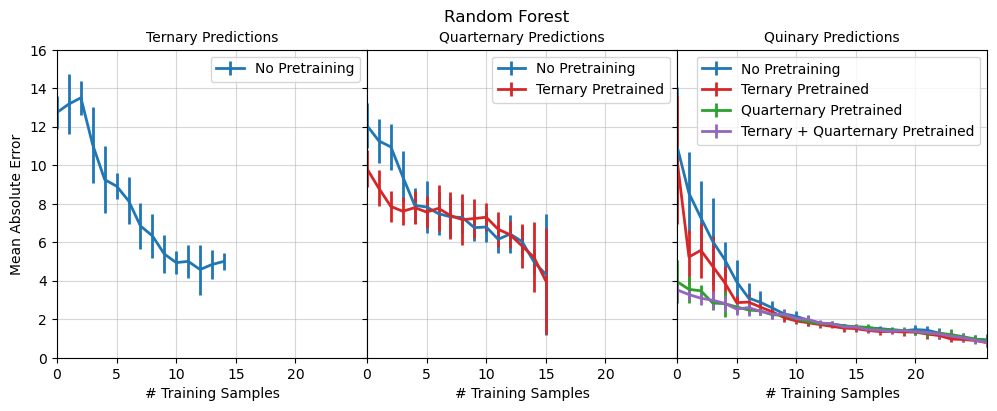

In [11]:
# now let's make the transfer learning figures

RF_error_fpaths = ['RFDT_ternary_only_transfer_learn.csv',
'RFDT_quarternary_only_transfer_learn.csv',
'RFDT_quinternary_only_transfer_learn.csv',
'RFDT_quarternary_from_ternary_transfer_learn.csv',
'RFDT_quinternary_from_ternary_transfer_learn.csv',
'RFDT_quinternary_from_quarternary_transfer_learn.csv',
'RFDT_quinternary_from_all_transfer_learn.csv']

df_labels = ['ternary','quarternary','quinternary']

# set the linewidth for the plot
linewidth = 2
markersize=10

# set colors for the various prediction compositions
cmaps = ['tab:blue','tab:blue','tab:blue','tab:red','tab:red','tab:green','tab:purple']
labels = ['No Pretraining','No Pretraining','No Pretraining','Ternary Pretrained','Ternary Pretrained','Quarternary Pretrained','Ternary + Quarternary Pretrained']


fig1,ax1 = plt.subplots(1,3,figsize=(12,4))
for ii,rf in enumerate(RF_error_fpaths):
    df = pd.read_csv('errors/' + rf,header=0)
    if '_quinternary_' in rf:
        ax1[2].errorbar(range(len(df['mae'])),df['mae'],yerr=df['yerr'],
                   c=cmaps[ii],label=labels[ii],
                   linewidth=linewidth)
    elif '_quarternary_only_' in rf or '_quarternary_from_' in rf:
        ax1[1].errorbar(range(len(df['mae'])),df['mae'],yerr=df['yerr'],
                   c=cmaps[ii],label=labels[ii],
                   linewidth=linewidth)
    elif '_ternary_only' in rf:
        ax1[0].errorbar(range(len(df['mae'])),df['mae'],yerr=df['yerr'],
                   c=cmaps[ii],label=labels[ii],
                   linewidth=linewidth)
    
titles = ['Ternary Predictions','Quarternary Predictions','Quinary Predictions',]
for ii in range(3):
    ax1[ii].set_xlabel('# Training Samples')
    ax1[ii].grid(alpha=0.5)
    ax1[ii].set_yticks([0,2,4,6,8,10,12,14,16])
    ax1[ii].set_xticks([0,5,10,15,20])
    ax1[ii].set_ylim(0,16)
    ax1[ii].set_xlim(0,26)
    ax1[ii].set_title(titles[ii],fontsize=10)
    ax1[ii].legend()
    if ii > 0:
        ax1[ii].set_yticklabels([])
ax1[0].set_ylabel('Mean Absolute Error')
plt.suptitle('Gaussian Process Regression')

plt.suptitle('Random Forest')

plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig('figures/RF_transfer_learn.png')